# Partie A – Clustering : Mall Customer Segmentation

Ce notebook couvre les étapes détaillées pour segmenter les clients d'un centre commercial en utilisant le dataset `Mall_Customers.csv`. Pour chaque étape, le code, les graphiques, les résultats et les interprétations sont fournis.


## 1. Configuration de l'environnement
Assurez-vous d'avoir installé les bibliothèques nécessaires. Si vous utilisez conda, créez un environnement comme suit :

```bash
conda create -n ds_mall python=3.9 jupyter numpy pandas scikit-learn matplotlib
conda activate ds_mall
```  
Ou avec pip dans un venv :

```bash
python -m venv venv_ds
source venv_ds/bin/activate  # ou venv_ds\Scripts\activate sur Windows
pip install jupyter numpy pandas scikit-learn matplotlib
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix

# Configurer l'affichage inline
%matplotlib inline

### 1.1 Chargement des données
Charger le fichier `Mall_Customers.csv`. Placez-le dans le même répertoire que ce notebook ou spécifiez le chemin approprié.

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 2. Nettoyage et prétraitement
### 2.1. Vérification des valeurs manquantes et types


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### 2.2. Gestion des valeurs manquantes
Le dataset ne devrait pas contenir de valeurs manquantes, mais si c'était le cas, on pourrait :
- Supprimer les lignes ou colonnes avec trop de valeurs manquantes
- Imputer (moyenne/médiane) pour les variables quantitatives


### 2.3. Sélection des variables pour le clustering
Généralement, on utilise :
- Age
- Annual Income (k$)
- Spending Score (1-100)
On peut aussi regarder Gender si on veut inclure une variable catégorielle (encodée).

In [5]:
# Conserver uniquement les colonnes d'intérêt
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

### 2.4. Standardisation
Standardiser les variables quantitatives avant clustering.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convertir en DataFrame pour faciliter la suite
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## 3. Exploratory Data Analysis (EDA)
### 3.1. Histogrammes et boxplots pour chaque variable

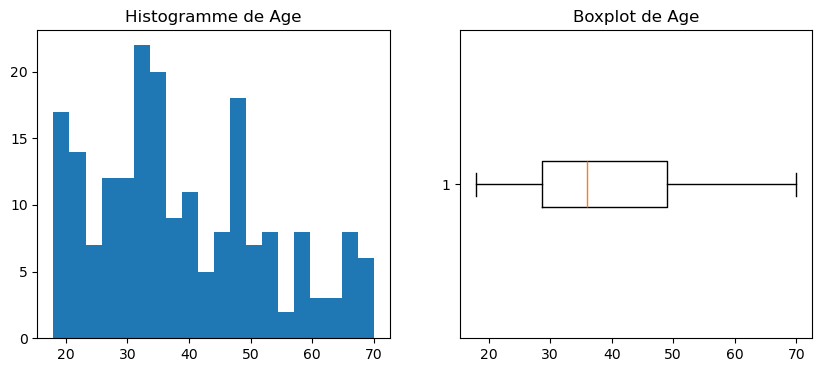

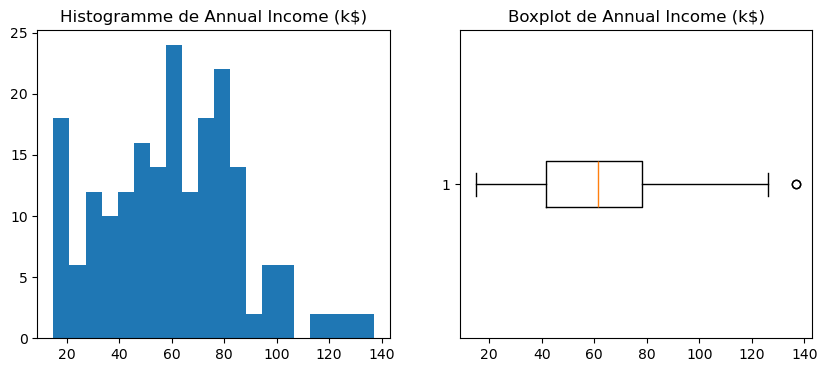

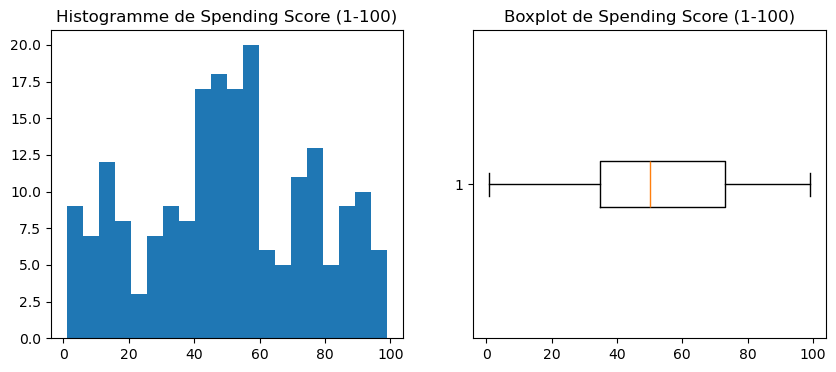

In [7]:
for col in features:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(df[col].dropna(), bins=20)
    axes[0].set_title(f'Histogramme de {col}')
    axes[1].boxplot(df[col].dropna(), vert=False)
    axes[1].set_title(f'Boxplot de {col}')
    plt.show()

### 3.2. Matrice de corrélation
Calcul et affichage de la correlation entre variables quantitatives.

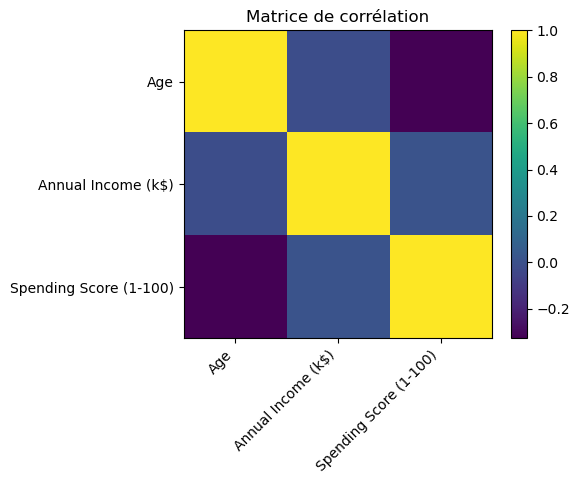

In [8]:
corr = df[features].corr()
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(corr, cmap='viridis')
ax.set_xticks(range(len(features))); ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right'); ax.set_yticklabels(features)
fig.colorbar(im, ax=ax)
ax.set_title('Matrice de corrélation')
plt.show()

### 3.3. Scatter plot matrix (pairplot)
Utilisation de scatter_matrix de pandas.

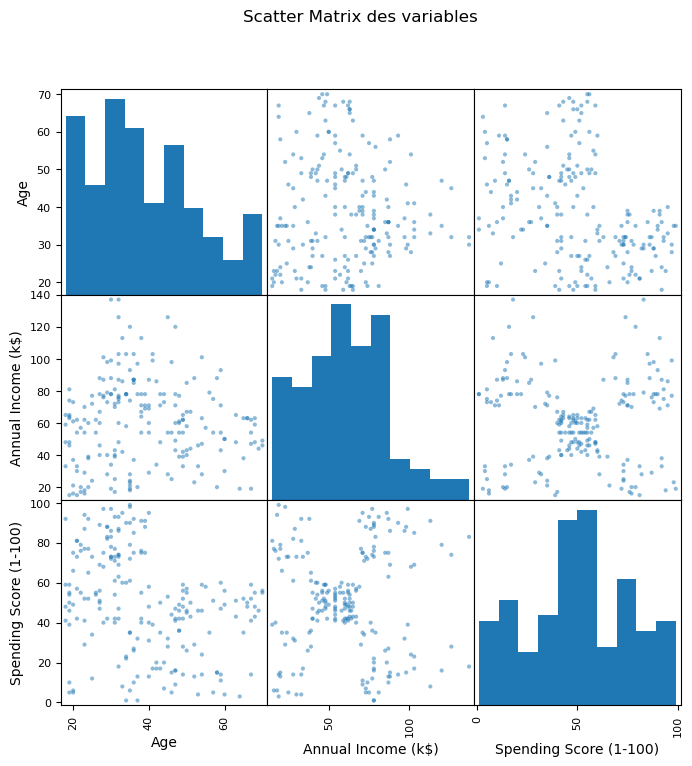

In [9]:
scatter_matrix(df[features], figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatter Matrix des variables')
plt.show()

## 4. Feature Engineering / Sélection
- Ici, pas de variables manifestement non-informatives à supprimer hormis CustomerID.
- On pourrait encoder Gender si souhaité, ou créer des classes d'âge.

In [10]:
# Exclure CustomerID au préalable, déjà fait. Exemple de catégorisation d'âge :
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100], labels=['Jeune', 'Adulte', 'Moyen', 'Senior'])
df['AgeGroup'].value_counts()

AgeGroup
Moyen     62
Adulte    60
Senior    40
Jeune     38
Name: count, dtype: int64

## 5. Réduction de dimension avec PCA
Appliquer PCA sur les données standardisées pour visualiser en 2D.

Variance expliquée par PC1 et PC2: [0.44266167 0.33308378]


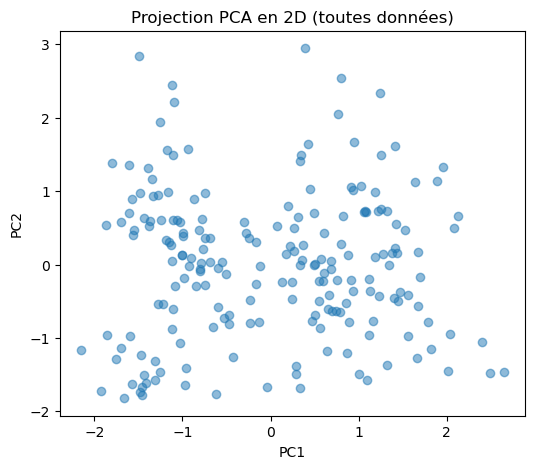

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# DataFrame pour visualisation
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# Variance expliquée
explained = pca.explained_variance_ratio_
print(f'Variance expliquée par PC1 et PC2: {explained}')

plt.figure(figsize=(6, 5))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA en 2D (toutes données)')
plt.show()

## 6. Clustering : K-means
Test de k de 2 à 6 en mesurant l'inertie et le score du silhouette.

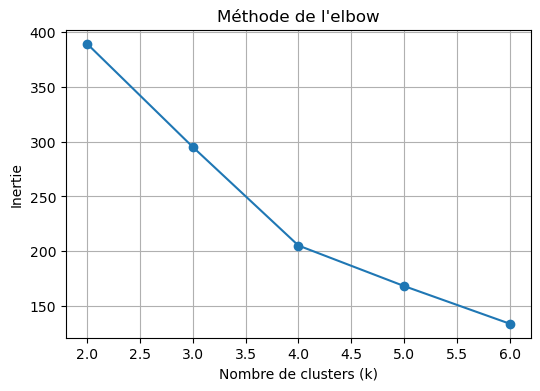

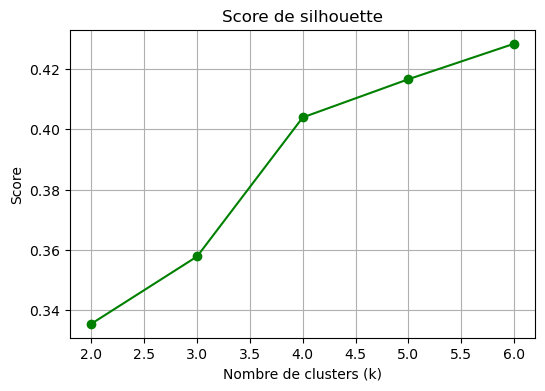

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


#chemin du dataset
df = pd.read_csv('Mall_Customers.csv')
df.head()

#standardisation
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

#clustering
inertias = []
sil_scores = []
k_range = range(2, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Méthode de l'elbow
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode de l'elbow")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()

# Score de silhouette
plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker='o', color='green')
plt.title("Score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score")
plt.grid(True)
plt.show()



### 6.1. Choix du k optimal
D'après les graphiques elbow et silhouette, choisir un k (par exemple).

In [25]:
# Supposons k_optimal déterminé comme 5 (à ajuster selon résultat)
k_optimal = 5
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled)
df['Cluster'] = labels_final

# Visualiser la taille de chaque cluster
df['Cluster'].value_counts().sort_index()

Cluster
0    58
1    40
2    26
3    45
4    31
Name: count, dtype: int64

## 7. Interprétation des clusters
### 7.1. Profils des clusters (centroïdes en valeur d'origine)

In [26]:
# Récupérer les centroïdes dans l'espace standardisé et revenir à l'échelle originale
centroids_scaled = kmeans_final.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
df_centroids = pd.DataFrame(centroids_orig, columns=features)
df_centroids['Cluster'] = range(k_optimal)
df_centroids

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,55.275862,47.620690,41.706897,0
1,32.875000,86.100000,81.525000,1
2,25.769231,26.115385,74.846154,2
3,26.733333,54.311111,40.911111,3
4,44.387097,89.774194,18.483871,4


### 7.2. Visualisation PCA colorée par cluster

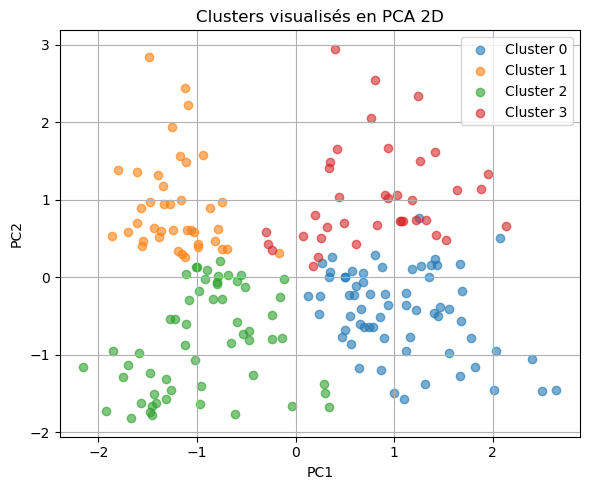

In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Convertir en DataFrame
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# 3. Appliquer KMeans avec k optimal (ex: k_optimal = 4)
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled)

# 4. Ajouter les labels au DataFrame PCA
df_pca['Cluster'] = labels_final

# 5. Visualiser les clusters en 2D avec couleurs
plt.figure(figsize=(6, 5))
for cluster in range(k_optimal):
    mask = (labels_final == cluster)
    plt.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters visualisés en PCA 2D')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 7.3. Analyse des caractéristiques par cluster

In [28]:
# Calcul des statistiques par cluster
cluster_stats = df.groupby('Cluster')[features].agg(['mean', 'median', 'count'])
cluster_stats

Age              Annual Income (k$)               \
              mean median count               mean median count   
Cluster                                                           
0        55.275862   53.0    58          47.620690   48.5    58   
1        32.875000   32.0    40          86.100000   78.5    40   
2        25.769231   24.0    26          26.115385   24.5    26   
3        26.733333   26.0    45          54.311111   59.0    45   
4        44.387097   44.0    31          89.774194   87.0    31   

        Spending Score (1-100)               
                          mean median count  
Cluster                                      
0                    41.706897   46.0    58  
1                    81.525000   83.0    40  
2                    74.846154   75.5    26  
3                    40.911111   46.0    45  
4                    18.483871   17.0    31

## 8. Conclusions
- Synthèse de la pertinence des clusters trouvés.
- Suggestions d'améliorations : essayer d'autres méthodes (DBSCAN, agglomératif), inclure d'autres variables, tester des transformations, etc.
- Remarques sur la stabilité, robustesse, et interprétabilité.
